**Importing liraries**

In [16]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm_notebook as tqdm

**Initializing Generator and Discriminator**

In [17]:
import torch.nn as nn

# Generator class
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        # Initialize input and output channels
        self.nz = nz
        self.channels = channels
        
        # Define a helper function to create a convolutional layer
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        # Build the model
        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # First layer: Fully connected layer achieved through convolution.
            *convlayer(1024, 512, 4, 2, 1),    # Second layer
            *convlayer(512, 256, 4, 2, 1),     # Third layer
            *convlayer(256, 128, 4, 2, 1),     # Fourth layer
            *convlayer(128, 64, 4, 2, 1),      # Fifth layer
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1), # Final layer to produce output with desired number of channels
            nn.Tanh() # Tanh activation function for the output
        )

    # Forward pass through the generator
    def forward(self, z):
        # Reshape input noise vector z to a batch of images
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        # Initialize input channels
        self.channels = channels

        # Define a helper function to create a convolutional layer
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        # Build the model
        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),  # First layer
            *convlayer(32, 64, 4, 2, 1),             # Second layer
            *convlayer(64, 128, 4, 2, 1, bn=True),   # Third layer with batch normalization
            *convlayer(128, 256, 4, 2, 1, bn=True),  # Fourth layer with batch normalization
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # Final layer: Fully connected layer through convolution
        )

    # Forward pass through the discriminator
    def forward(self, imgs):
        # Pass the images through the model
        out = self.model(imgs)
        # Flatten the output
        return out.view(-1, 1)

**Importing Dataset**

In [18]:
import zipfile  # Import the zipfile module to work with ZIP files
import os       # Import the os module for interacting with the operating system

# Path to the zip file
zip_path = '/kaggle/input/generative-dog-images/all-dogs.zip'  # Define the path to the ZIP file

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:  # Open the ZIP file in read mode
    zip_ref.extractall('all-dogs')  # Extract all the contents of the ZIP file to a folder named 'all-dogs'

# Now, you can list the contents of the extracted folder
extracted_files = os.listdir('all-dogs')  # List all files in the newly created 'all-dogs' directory
print(extracted_files)  # Print the list of files

['all-dogs']


**Training Parameters**

In [19]:
# Training parameters
batch_size = 32  # Batch size for training. Determines how many samples are processed before the model is updated.
lr = 0.001       # Learning rate. Determines the step size at each iteration while moving toward a minimum of a loss function.
beta1 = 0.5      # Beta1 hyperparameter for Adam optimizer. It's the exponential decay rate for the first moment estimates.
epochs = 40     # Number of epochs. Determines how many times the learning algorithm will work through the entire training dataset.

# Labeling for discriminator
real_label = 0.5  # Label for real images. Typically set to 1, but can be smoothed to prevent overconfidence.
fake_label = 0    # Label for fake (generated) images.

# Size of the latent vector (noise vector)
nz = 128  # Dimension of the latent z vector. This is the size of the generator input.

# Setting up the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
# This will use CUDA (GPU acceleration) if available, otherwise CPU.

**Loading dataset and applying preprocessing**

In [20]:
from torch.utils.data import Dataset
from PIL import Image
import os

class DogDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
        # Constructor of the DogDataset class
        self.img_dir = img_dir  # Directory where the images are stored
        self.img_names = os.listdir(img_dir)  # List all files in the image directory
        self.transform1 = transform1  # First transformation to apply to the images
        self.transform2 = transform2  # Second transformation to apply to the images

        # Load and optionally transform all images in the directory
        self.imgs = []  # List to store the loaded images
        for img_name in self.img_names:
            # Open each image
            img = Image.open(os.path.join(img_dir, img_name))

            # Apply the first transformation if it is defined
            if self.transform1 is not None:
                img = self.transform1(img)

            # Add the (transformed) image to the list
            self.imgs.append(img)

    def __getitem__(self, index):
        # Method to get an image by index
        img = self.imgs[index]  # Retrieve the image from the list

        # Apply the second transformation if it is defined
        if self.transform2 is not None:
            img = self.transform2(img)

        # Return the possibly transformed image
        return img

    def __len__(self):
        # Method to get the total number of images
        return len(self.imgs)  # Return the length of the image list

**Preprocessing code to apply to dataset**

In [21]:
# Image Preprocessing
transform1 = transforms.Compose([
    transforms.Resize(64),        # Resize the image to 64x64 pixels
    transforms.CenterCrop(64)     # Crop the image to a 64x64 square centered on the middle of the image
])

# Data augmentation and conversion to tensor
random_transforms = [transforms.RandomRotation(degrees=5)]  # Define random rotation transformation
transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the images horizontally with a probability of 0.5
    transforms.RandomApply(random_transforms, p=0.3),  # Apply the random rotation with a probability of 0.3
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensors
])

# Creating the dataset
train_dataset = DogDataset(img_dir='/kaggle/working/all-dogs/all-dogs/',
                           transform1=transform1,
                           transform2=transform2)

# DataLoader for the dataset
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,  # Load data in batches
                          shuffle=True,           # Shuffle the data to reduce model overfitting
                          num_workers=4)          # Number of subprocesses to use for data loading

# Loading a batch of images
imgs = next(iter(train_loader))  # Get the first batch of images
imgs = imgs.numpy().transpose(0, 2, 3, 1)  # Convert the images from PyTorch tensor to numpy array and change the shape

**Preview of images from the dataset**

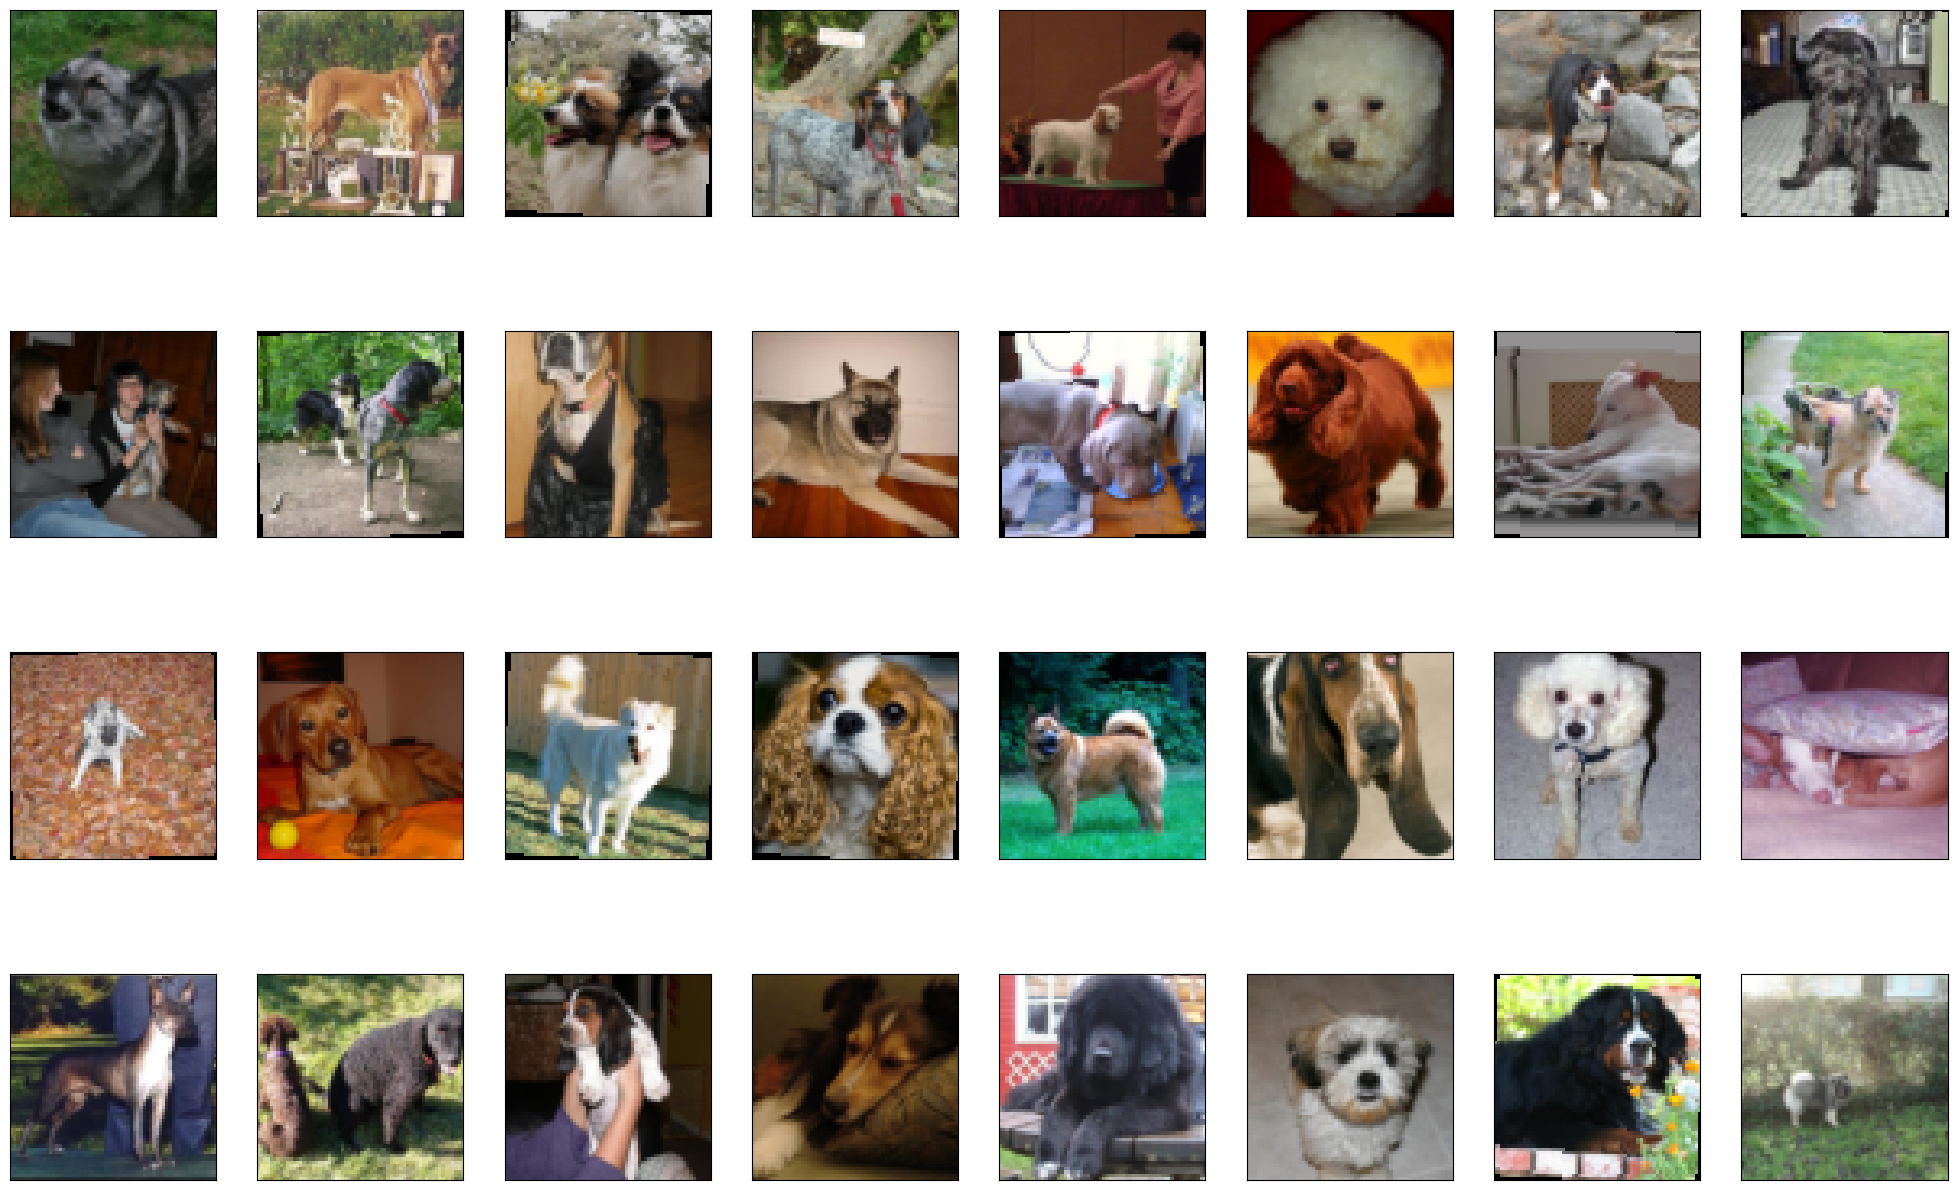

In [22]:
fig = plt.figure(figsize=(25, 16))  # Create a new figure for plotting, with a specified size (width 25 inches, height 16 inches)

# Loop through the images in the batch
for ii, img in enumerate(imgs):
    # Create a subplot for each image
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])  
    # Adds a subplot at the ii-th position in a grid that's 4 rows by 8 columns.
    # 'xticks=[]' and 'yticks=[]' remove the x and y tick marks from the plots.

    # Display the image
    plt.imshow((img+1)/2)  
    # The images are normalized between -1 and 1, so (img+1)/2 rescales them to the range [0,1].
    # This is necessary for matplotlib to display them correctly.

**Creating both networks and applying an optimizer to both**

In [23]:
# Creating the Generator network
netG = Generator(nz).to(device)  
# Initialize the Generator with the specified noise vector size (nz).
# The .to(device) method moves the model to a GPU if available, otherwise to the CPU.

# Creating the Discriminator network
netD = Discriminator().to(device)
# Initialize the Discriminator.
# The .to(device) method moves the model to a GPU if available, otherwise to the CPU.

# Setting up the loss function
criterion = nn.BCELoss()  
# Binary Cross Entropy Loss is used, typical for GANs as the discriminator outputs a binary classification (real or fake).

# Setting up the Optimizer for the Discriminator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))  
# Use the Adam optimizer for the discriminator.
# 'lr' is the learning rate, and 'betas' are the hyperparameters for the Adam optimizer.

# Setting up the Optimizer for the Generator
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))  
# Use the Adam optimizer for the generator, similar to the discriminator.

# Creating a fixed noise vector for evaluating the Generator's performance
fixed_noise = torch.randn(25, nz, 1, 1, device=device)  
# Generate a fixed random noise vector with 25 samples, each of size 'nz'.
# The noise vector is used to evaluate the generator's output.
# The .to(device) method moves the noise vector to the same device as the model.

**Generate an image from a random noisy input**

In [24]:
def show_generated_img():
    # Generate a random noise vector
    noise = torch.randn(1, nz, 1, 1, device=device)  
    # Create a random noise vector with the same size as the generator's input.
    # The noise vector has dimensions [1, nz, 1, 1], where 1 is the batch size.

    # Generate an image from the noise vector using the generator network
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)  
    # Pass the noise through the generator to create an image.
    # .to("cpu") moves the image to the CPU for visualization.
    # .clone().detach() creates a copy of the image tensor and detaches it from the current computation graph.
    # .squeeze(0) removes the first dimension (batch dimension) to make it suitable for displaying.

    # Convert the image tensor to a numpy array and adjust its dimensions for plotting
    gen_image = gen_image.numpy().transpose(1, 2, 0)  
    # Convert the PyTorch tensor to a numpy array.
    # Transpose the dimensions from [channels, height, width] to [height, width, channels] for displaying.

    # Display the image
    plt.imshow((gen_image+1)/2)  
    # The images are normalized between -1 and 1, so (gen_image+1)/2 rescales them to the range [0,1].
    # This rescaling is necessary for matplotlib to display the images correctly.

    plt.show()  # Show the image

**Training code**

/tmp/ipykernel_43/861232569.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/644 [00:00<?, ?it/s]

[1/40][322/644] Loss_D: 0.1588 Loss_G: 0.5871
[1/40][644/644] Loss_D: 0.3741 Loss_G: 2.6823


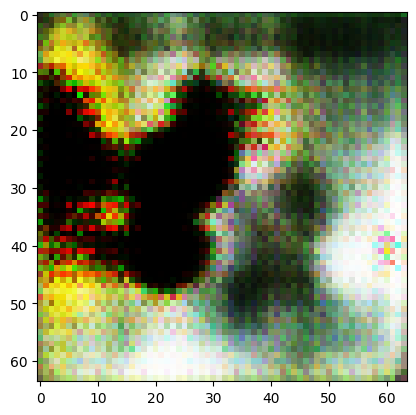

  0%|          | 0/644 [00:00<?, ?it/s]

[2/40][322/644] Loss_D: 0.0791 Loss_G: 1.0463
[2/40][644/644] Loss_D: 0.0539 Loss_G: 2.0900


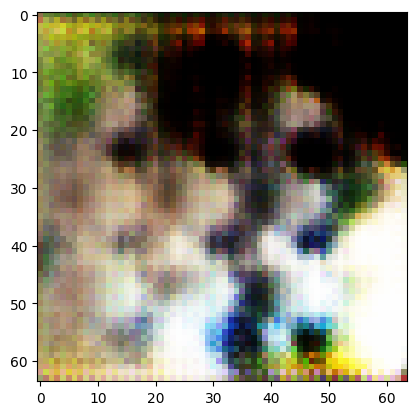

  0%|          | 0/644 [00:00<?, ?it/s]

[3/40][322/644] Loss_D: 0.1182 Loss_G: 1.2635
[3/40][644/644] Loss_D: 0.1161 Loss_G: 0.4358


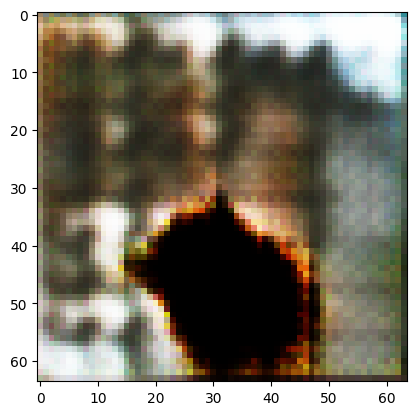

  0%|          | 0/644 [00:00<?, ?it/s]

[4/40][322/644] Loss_D: 0.2356 Loss_G: 0.9238
[4/40][644/644] Loss_D: 0.2959 Loss_G: 5.6874


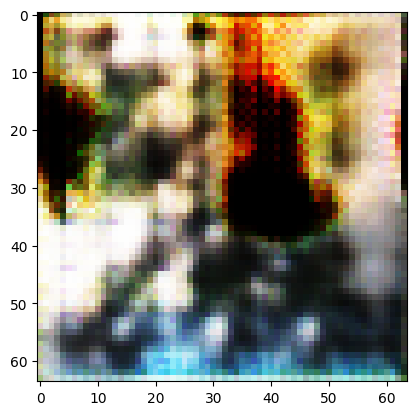

  0%|          | 0/644 [00:00<?, ?it/s]

[5/40][322/644] Loss_D: 0.3093 Loss_G: 0.8864
[5/40][644/644] Loss_D: 0.1834 Loss_G: 4.3425


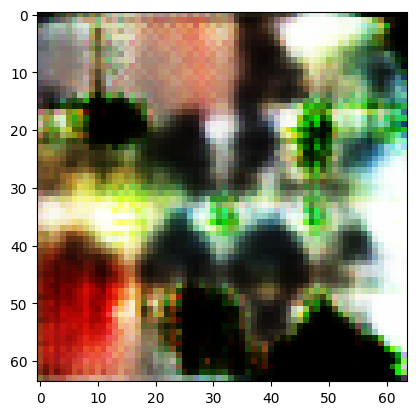

  0%|          | 0/644 [00:00<?, ?it/s]

[6/40][322/644] Loss_D: 0.0893 Loss_G: 0.9861
[6/40][644/644] Loss_D: 0.3507 Loss_G: 3.7826


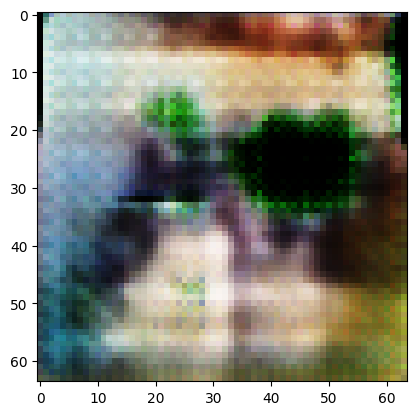

  0%|          | 0/644 [00:00<?, ?it/s]

[7/40][322/644] Loss_D: 0.1998 Loss_G: 1.5418
[7/40][644/644] Loss_D: 0.2465 Loss_G: 5.6877


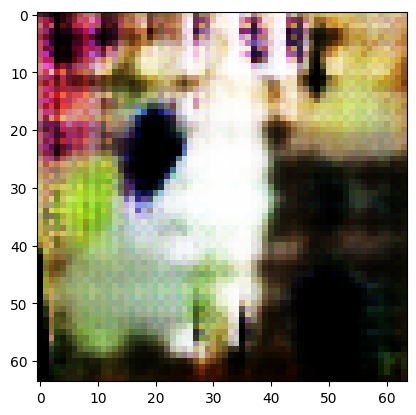

  0%|          | 0/644 [00:00<?, ?it/s]

[8/40][322/644] Loss_D: 0.1597 Loss_G: 0.9794
[8/40][644/644] Loss_D: 0.5671 Loss_G: 4.3414


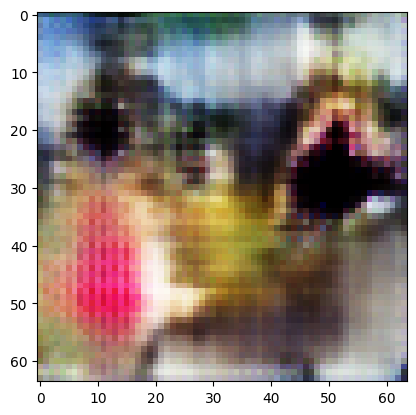

  0%|          | 0/644 [00:00<?, ?it/s]

[9/40][322/644] Loss_D: 0.1337 Loss_G: 0.8453
[9/40][644/644] Loss_D: 0.1067 Loss_G: 2.3980


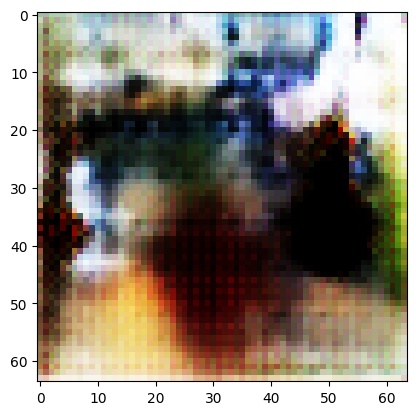

  0%|          | 0/644 [00:00<?, ?it/s]

[10/40][322/644] Loss_D: 0.1711 Loss_G: 0.7606
[10/40][644/644] Loss_D: 0.3364 Loss_G: 2.9572


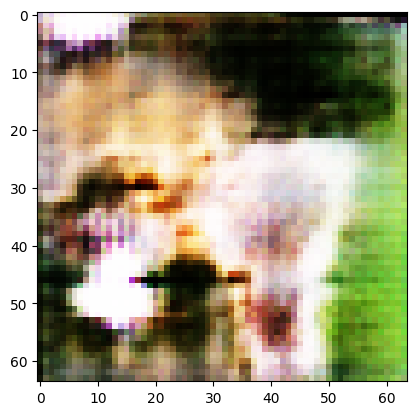

  0%|          | 0/644 [00:00<?, ?it/s]

[11/40][322/644] Loss_D: 0.0967 Loss_G: 1.0128
[11/40][644/644] Loss_D: 0.0103 Loss_G: 1.0144


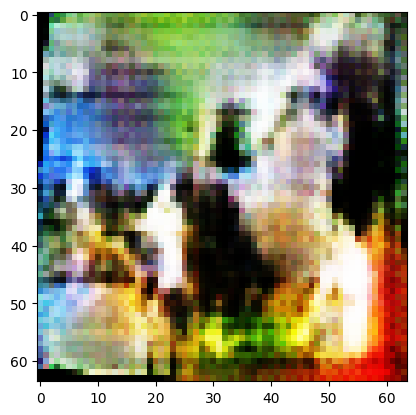

  0%|          | 0/644 [00:00<?, ?it/s]

[12/40][322/644] Loss_D: 0.2278 Loss_G: 0.5559
[12/40][644/644] Loss_D: 0.1557 Loss_G: 2.2178


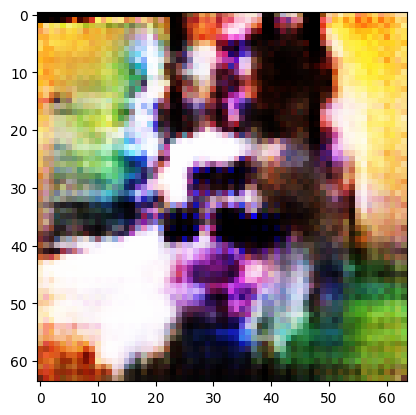

  0%|          | 0/644 [00:00<?, ?it/s]

[13/40][322/644] Loss_D: 0.2209 Loss_G: 0.6482
[13/40][644/644] Loss_D: 0.4162 Loss_G: 1.6767


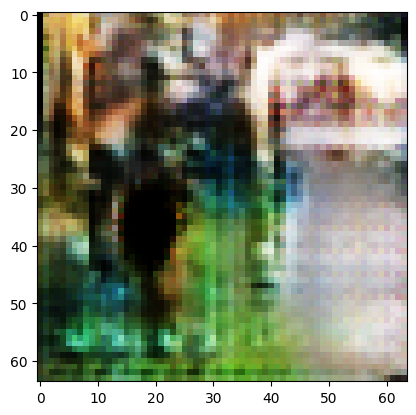

  0%|          | 0/644 [00:00<?, ?it/s]

[14/40][322/644] Loss_D: 0.2281 Loss_G: 0.4652
[14/40][644/644] Loss_D: 0.2035 Loss_G: 1.5943


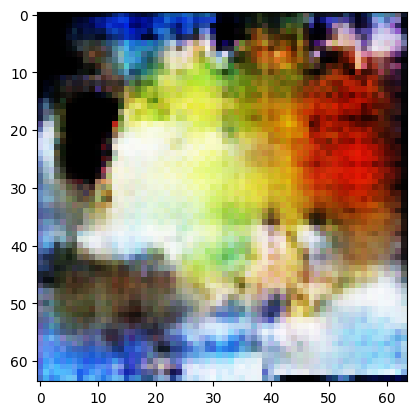

  0%|          | 0/644 [00:00<?, ?it/s]

[15/40][322/644] Loss_D: 0.2419 Loss_G: 0.5200
[15/40][644/644] Loss_D: 0.3145 Loss_G: 2.2270


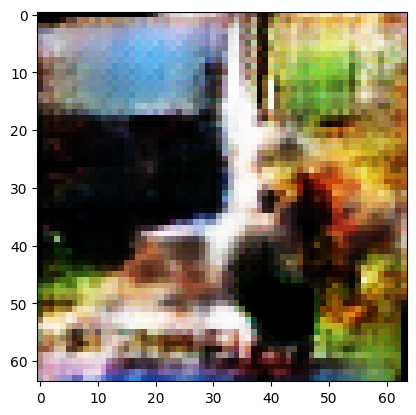

  0%|          | 0/644 [00:00<?, ?it/s]

[16/40][322/644] Loss_D: 0.1610 Loss_G: 0.6680
[16/40][644/644] Loss_D: 0.1860 Loss_G: 1.5136


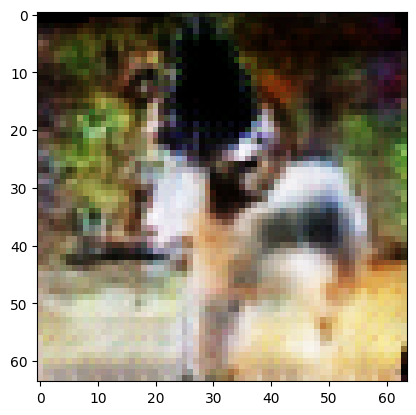

  0%|          | 0/644 [00:00<?, ?it/s]

[17/40][322/644] Loss_D: 0.1647 Loss_G: 0.6496
[17/40][644/644] Loss_D: 0.1287 Loss_G: 1.9704


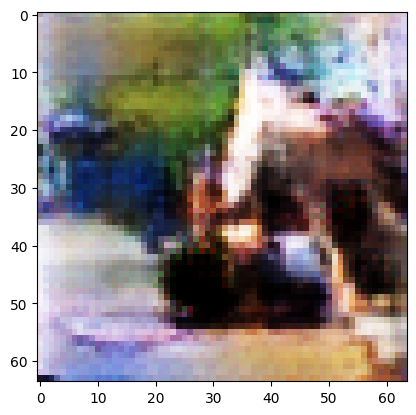

  0%|          | 0/644 [00:00<?, ?it/s]

[18/40][322/644] Loss_D: 0.3200 Loss_G: 0.4562
[18/40][644/644] Loss_D: 0.3284 Loss_G: 1.5898


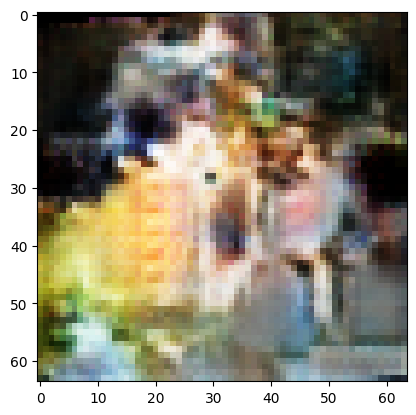

  0%|          | 0/644 [00:00<?, ?it/s]

[19/40][322/644] Loss_D: 0.1493 Loss_G: 0.7300
[19/40][644/644] Loss_D: 0.1040 Loss_G: 1.5515


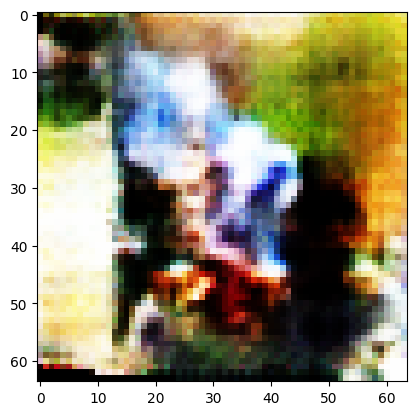

  0%|          | 0/644 [00:00<?, ?it/s]

[20/40][322/644] Loss_D: 0.2456 Loss_G: 0.5737
[20/40][644/644] Loss_D: 0.5454 Loss_G: 1.4948


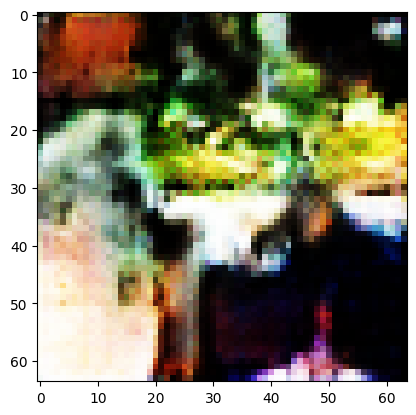

  0%|          | 0/644 [00:00<?, ?it/s]

[21/40][322/644] Loss_D: 0.2229 Loss_G: 0.5297
[21/40][644/644] Loss_D: 0.1297 Loss_G: 1.9225


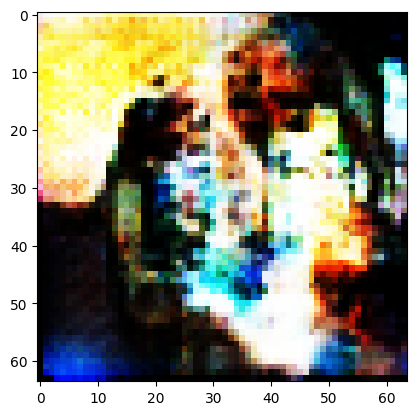

  0%|          | 0/644 [00:00<?, ?it/s]

[22/40][322/644] Loss_D: 0.1290 Loss_G: 0.6874
[22/40][644/644] Loss_D: 0.1668 Loss_G: 2.6874


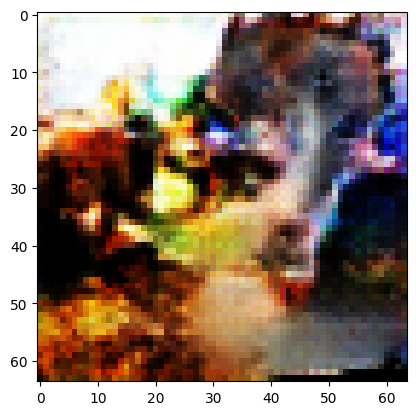

  0%|          | 0/644 [00:00<?, ?it/s]

[23/40][322/644] Loss_D: 0.1996 Loss_G: 0.8534
[23/40][644/644] Loss_D: 0.3748 Loss_G: 2.3356


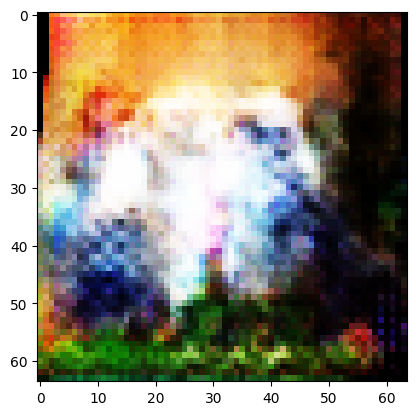

  0%|          | 0/644 [00:00<?, ?it/s]

[24/40][322/644] Loss_D: 0.1995 Loss_G: 0.5977
[24/40][644/644] Loss_D: 0.0792 Loss_G: 0.6700


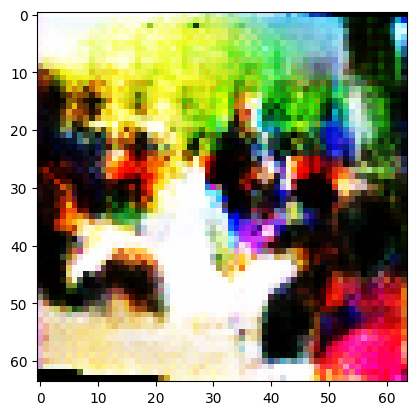

  0%|          | 0/644 [00:00<?, ?it/s]

[25/40][322/644] Loss_D: 0.1604 Loss_G: 0.7283
[25/40][644/644] Loss_D: 0.1673 Loss_G: 2.8688


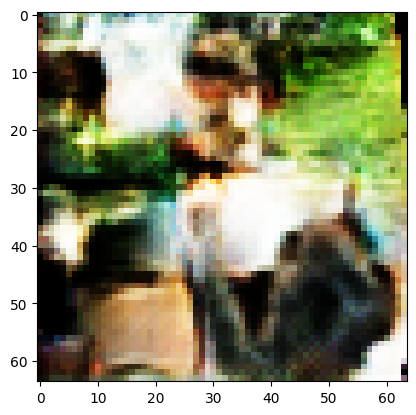

  0%|          | 0/644 [00:00<?, ?it/s]

[26/40][322/644] Loss_D: 0.1753 Loss_G: 0.6234
[26/40][644/644] Loss_D: 0.2425 Loss_G: 3.1248


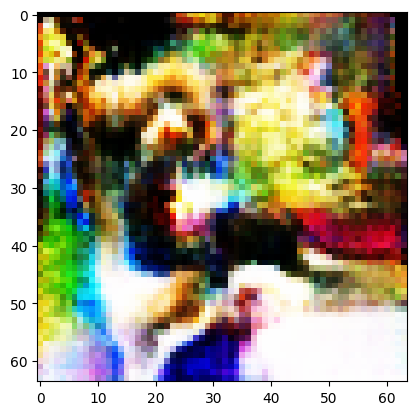

  0%|          | 0/644 [00:00<?, ?it/s]

[27/40][322/644] Loss_D: 0.2258 Loss_G: 0.7479
[27/40][644/644] Loss_D: 0.2779 Loss_G: 4.1388


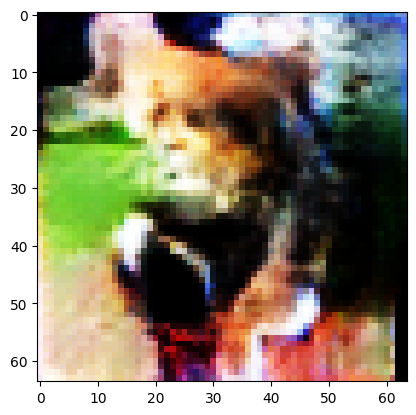

  0%|          | 0/644 [00:00<?, ?it/s]

[28/40][322/644] Loss_D: 0.1213 Loss_G: 0.8313
[28/40][644/644] Loss_D: 0.2170 Loss_G: 3.5334


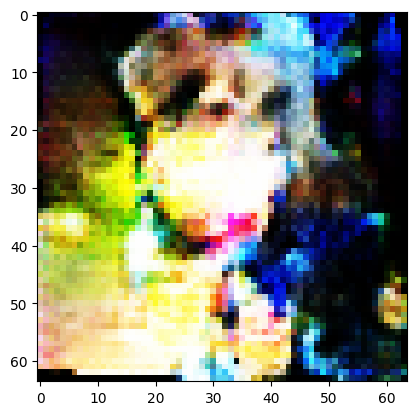

  0%|          | 0/644 [00:00<?, ?it/s]

[29/40][322/644] Loss_D: 0.1194 Loss_G: 0.7497
[29/40][644/644] Loss_D: 0.4296 Loss_G: 4.7490


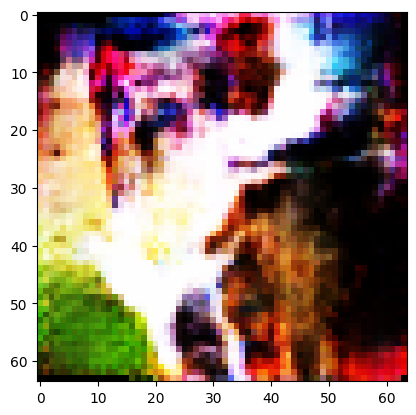

  0%|          | 0/644 [00:00<?, ?it/s]

[30/40][322/644] Loss_D: 0.1652 Loss_G: 1.1551
[30/40][644/644] Loss_D: 0.1683 Loss_G: 4.0535


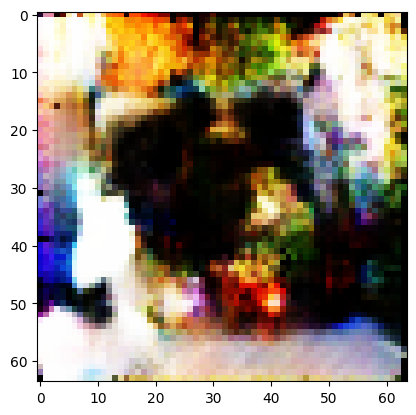

  0%|          | 0/644 [00:00<?, ?it/s]

[31/40][322/644] Loss_D: 0.1975 Loss_G: 0.8366
[31/40][644/644] Loss_D: 0.1257 Loss_G: 2.2835


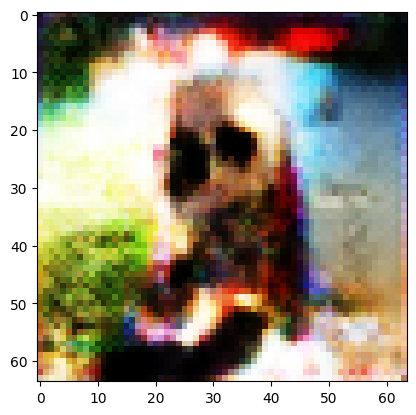

  0%|          | 0/644 [00:00<?, ?it/s]

[32/40][322/644] Loss_D: 0.1093 Loss_G: 0.8417
[32/40][644/644] Loss_D: 0.0692 Loss_G: 2.8388


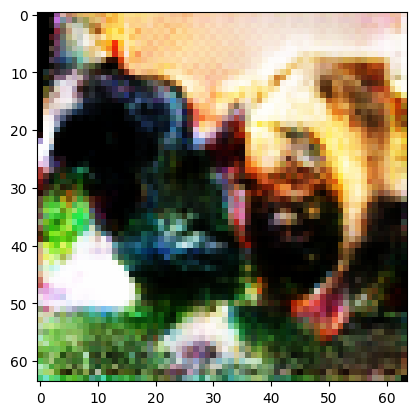

  0%|          | 0/644 [00:00<?, ?it/s]

[33/40][322/644] Loss_D: 0.1251 Loss_G: 0.7194
[33/40][644/644] Loss_D: 0.5308 Loss_G: 4.7791


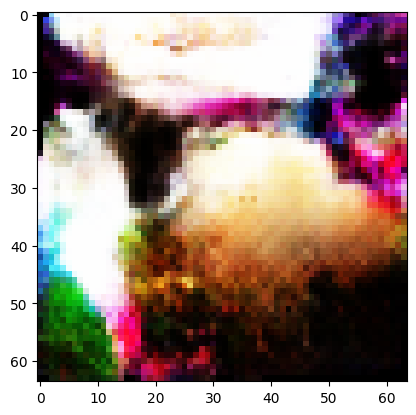

  0%|          | 0/644 [00:00<?, ?it/s]

[34/40][322/644] Loss_D: 0.2043 Loss_G: 0.6482
[34/40][644/644] Loss_D: 0.2781 Loss_G: 2.1910


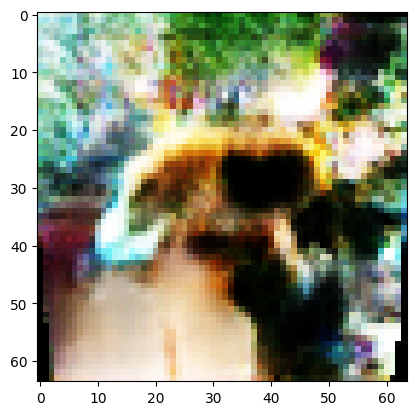

  0%|          | 0/644 [00:00<?, ?it/s]

[35/40][322/644] Loss_D: 0.0651 Loss_G: 1.0039
[35/40][644/644] Loss_D: 0.4354 Loss_G: 6.8447


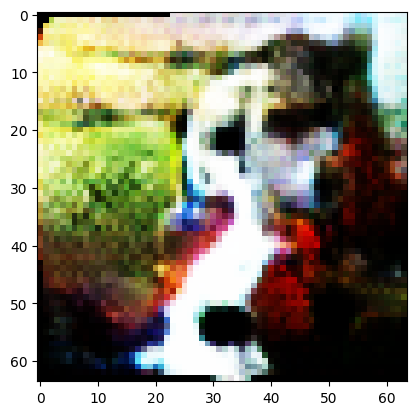

  0%|          | 0/644 [00:00<?, ?it/s]

[36/40][322/644] Loss_D: 0.0410 Loss_G: 1.0716
[36/40][644/644] Loss_D: 0.2406 Loss_G: 5.7580


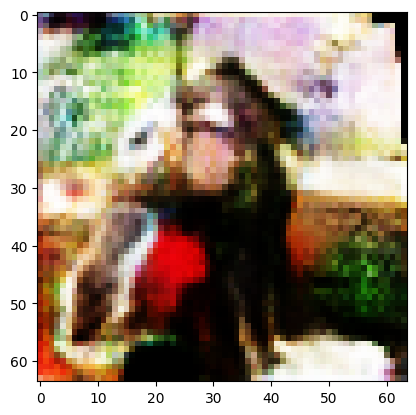

  0%|          | 0/644 [00:00<?, ?it/s]

[37/40][322/644] Loss_D: 0.1269 Loss_G: 0.8714
[37/40][644/644] Loss_D: 0.0983 Loss_G: 4.0024


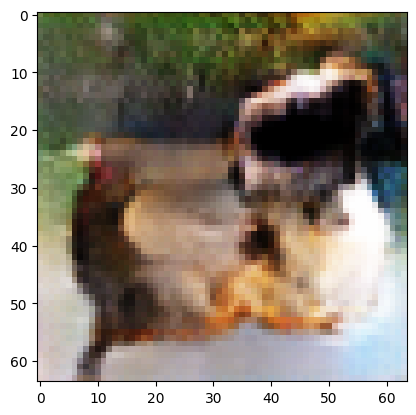

  0%|          | 0/644 [00:00<?, ?it/s]

[38/40][322/644] Loss_D: 0.2237 Loss_G: 1.1203
[38/40][644/644] Loss_D: 0.2916 Loss_G: 3.8797


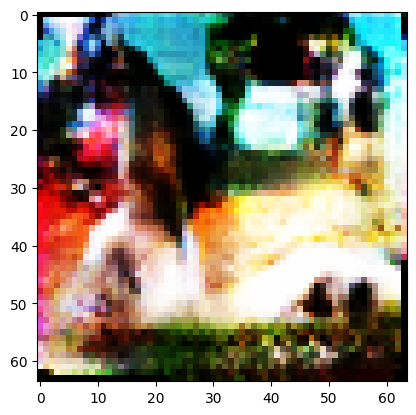

  0%|          | 0/644 [00:00<?, ?it/s]

[39/40][322/644] Loss_D: 0.0548 Loss_G: 1.1039
[39/40][644/644] Loss_D: 0.6797 Loss_G: 7.9001


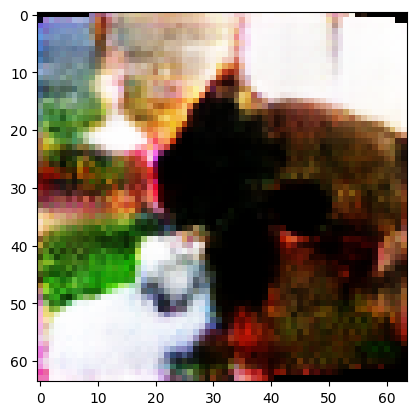

  0%|          | 0/644 [00:00<?, ?it/s]

[40/40][322/644] Loss_D: 0.1599 Loss_G: 0.7619
[40/40][644/644] Loss_D: 0.2619 Loss_G: 4.6363


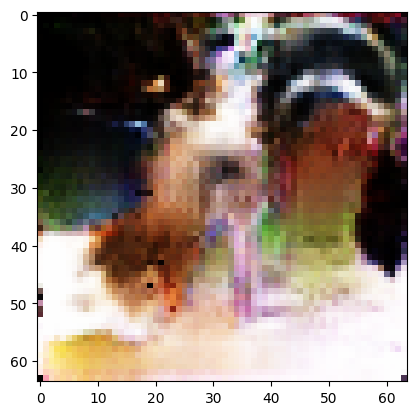

In [25]:
# Loop over all epochs
for epoch in range(epochs):
    
    # Loop over the batches of images
    for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        # Update Discriminator network:
        # ----------------------------
        netD.zero_grad()  # Reset gradients for the discriminator

        # Move real images to the appropriate device (GPU or CPU)
        real_images = real_images.to(device)

        # Create labels for real images
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        # Forward pass real images through D
        outputR = netD(real_images)

        # Generate fake images with G
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)

        # Forward pass fake images through D
        outputF = netD(fake.detach())

        # Calculate loss for D and perform backward pass
        errD = (torch.mean((outputR - torch.mean(outputF) - labels) ** 2) + 
                torch.mean((outputF - torch.mean(outputR) + labels) ** 2)) / 2
        errD.backward(retain_graph=True)
        optimizerD.step()

        # Update Generator network:
        # -------------------------
        netG.zero_grad()  # Reset gradients for the generator

        # Forward pass fake images through D again
        outputF = netD(fake)

        # Calculate loss for G and perform backward pass
        errG = (torch.mean((outputR - torch.mean(outputF) + labels) ** 2) +
                torch.mean((outputF - torch.mean(outputR) - labels) ** 2)) / 2
        errG.backward()
        optimizerG.step()

        # Print statistics
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item()))

    # Show a generated image after each epoch
    show_generated_img()

**Save both networks**

In [26]:
# Save the Generator's state
torch.save(netG.state_dict(), 'generator.pth')  
# 'netG.state_dict()' retrieves the state (weights and biases) of the generator network (netG).
# This state is saved to a file named 'generator.pth'.
# The '.pth' extension is commonly used for PyTorch model files.

# Save the Discriminator's state
torch.save(netD.state_dict(), 'discriminator.pth')  
# 'netD.state_dict()' retrieves the state (weights and biases) of the discriminator network (netD).
# This state is saved to a file named 'discriminator.pth'.
# The '.pth' extension is commonly used for PyTorch model files.

**Generate a random set of images**

In [27]:
# Generate random noise vectors
gen_z = torch.randn(32, nz, 1, 1, device=device)  
# This creates a batch of 32 random noise vectors, each of size 'nz'.
# The noise vectors are the input to the generator.
# The dimensions of the tensor are [batch_size, nz, 1, 1].
# 'device=device' ensures that the operation is performed on the same device (GPU/CPU) as the model.

# Generate images from the noise vectors using the generator
gen_images = (netG(gen_z).to("cpu").clone().detach() + 1) / 2
# 'netG(gen_z)' passes the noise vectors through the generator to produce a batch of images.
# '.to("cpu")' moves the generated images to the CPU. This is necessary for converting them into numpy arrays later.
# '.clone().detach()' creates a copy of the images and detaches them from the current computation graph.
# '(... + 1) / 2' rescales the pixel values from the range [-1, 1] to [0, 1].
# This rescaling is necessary because the generator often uses Tanh activation in the output layer, resulting in outputs in the range [-1, 1].

# Convert the images to numpy arrays for visualization
gen_images = gen_images.numpy().transpose(0, 2, 3, 1)  
# '.numpy()' converts the tensor of generated images to a numpy array.
# '.transpose(0, 2, 3, 1)' changes the shape of the array from [batch, channels, height, width] to [batch, height, width, channels].
# This transposition is required for visualization purposes, as most visualization libraries expect the channel dimension to be last.

**Display the randomly generated images**

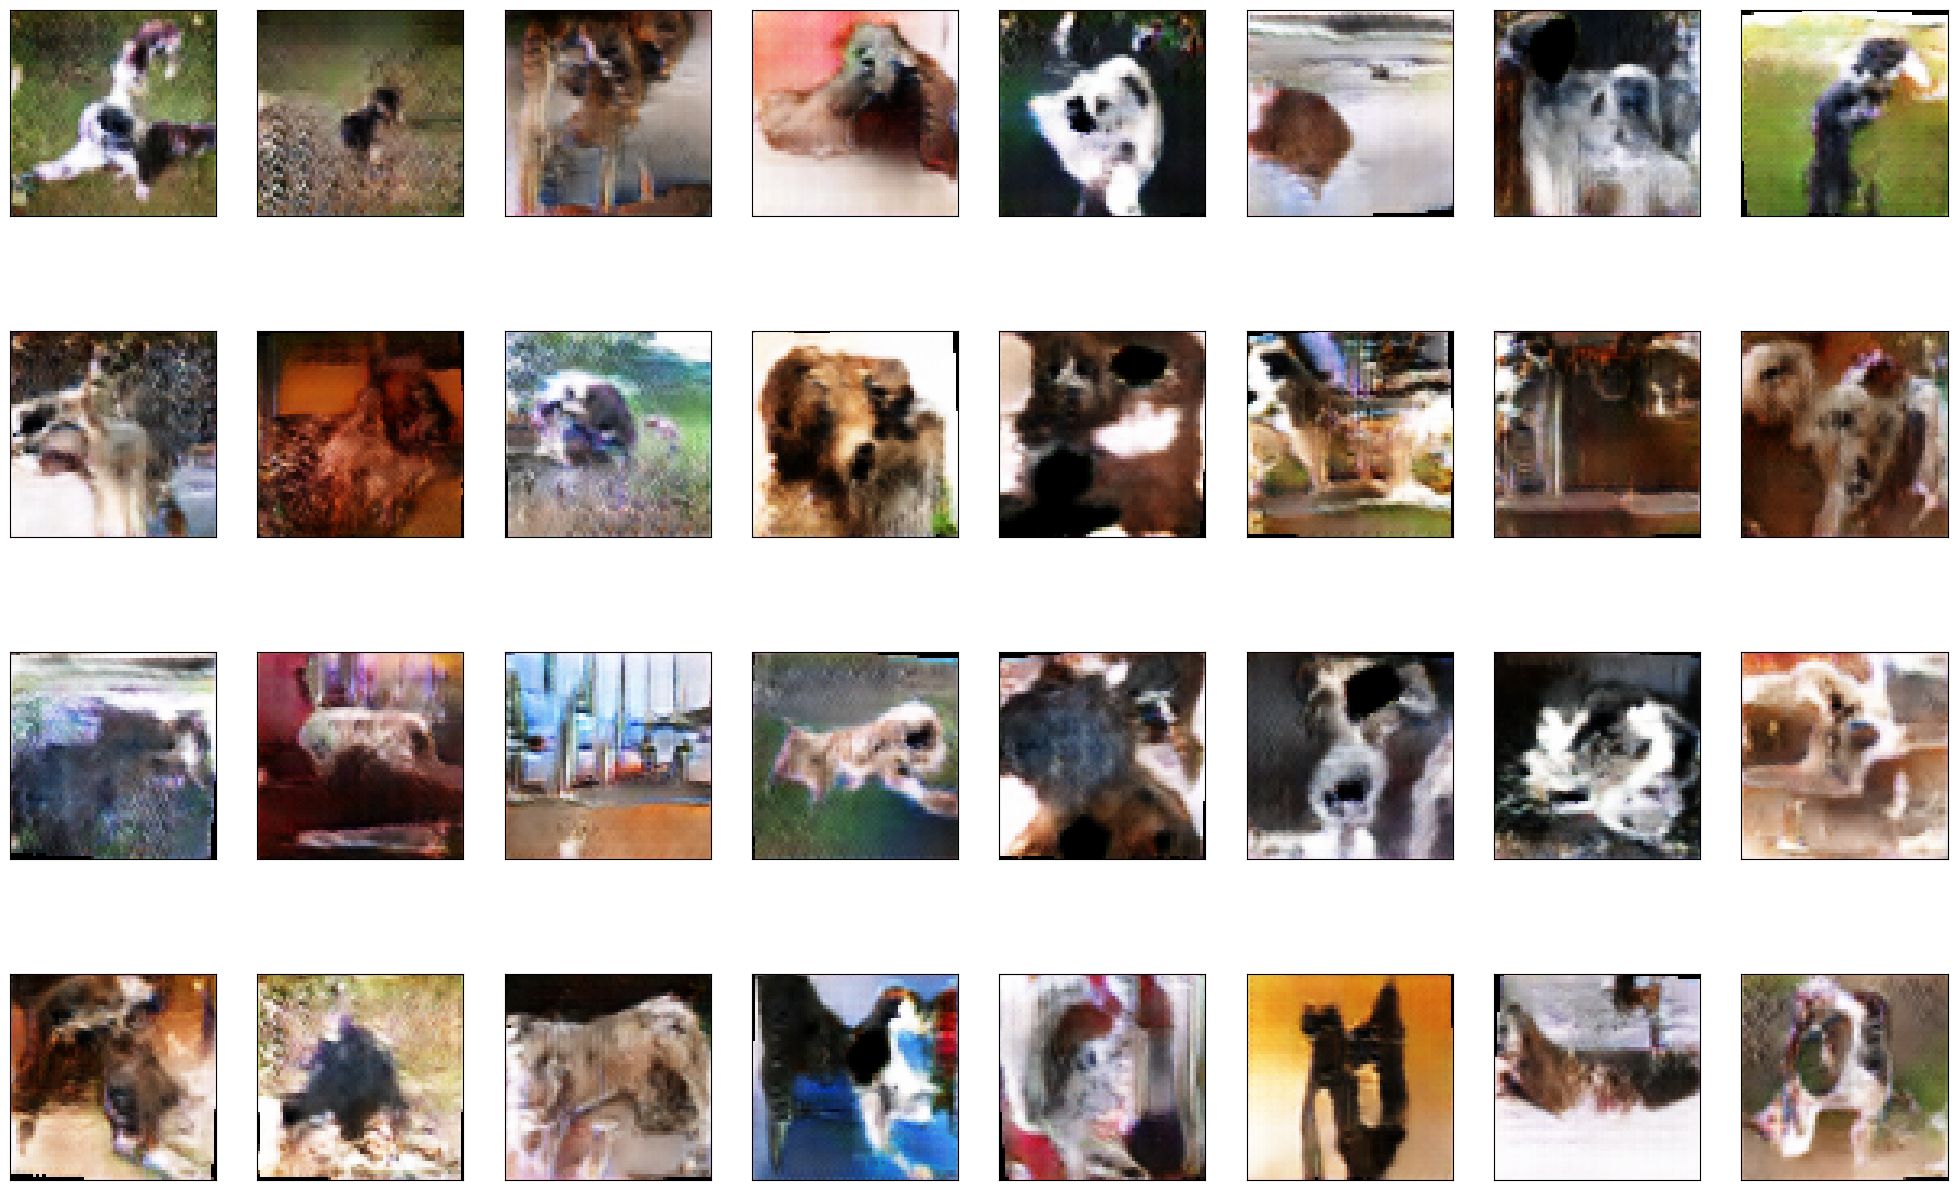

In [28]:
# Create a figure for plotting the images
fig = plt.figure(figsize=(25, 16))  
# 'figsize=(25, 16)' sets the size of the figure to 25 inches wide and 16 inches tall.
# This large size helps in better visualization of multiple images.

# Loop through the generated images
for ii, img in enumerate(gen_images):
    # Add a subplot for each image in the figure
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])  
    # '4, 8' means the grid will have 4 rows and 8 columns.
    # 'ii + 1' is the position of the subplot in the grid.
    # 'xticks=[]' and 'yticks=[]' remove the x and y axis tick marks for each subplot.

    # Display the image in the subplot
    plt.imshow(img)  
    # 'plt.imshow' displays the image. 'img' is the current image in the loop.

# Show the complete figure with all subplots
plt.show()  
# 'plt.show()' renders the whole figure. It should be called after all subplots are added.

**Save generated images into a zip file**

In [29]:
# Check if the output directory exists, if not, create it
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')  
    # '../output_images' is the directory where generated images will be saved.
    # 'os.mkdir' creates the directory if it does not already exist.

# Define batch size for image generation and total number of images to generate
im_batch_size = 50  # Number of images to generate in each batch.
n_images = 10000    # Total number of images to generate.

# Generate and save images in batches
for i_batch in range(0, n_images, im_batch_size):
    # Generate a batch of noise vectors
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)  
    # 'torch.randn' generates a tensor of random values from a normal distribution.
    # The tensor has dimensions [im_batch_size, nz, 1, 1].

    # Generate images from the noise vectors
    gen_images = (netG(gen_z) + 1) / 2  
    # 'netG(gen_z)' generates a batch of images.
    # '(... + 1) / 2' rescales the images from [-1, 1] to [0, 1].

    # Prepare images for saving
    images = gen_images.to("cpu").clone().detach()  
    # Move images to CPU and detach from computation graph.
    images = images.numpy().transpose(0, 2, 3, 1)  
    # Convert to numpy array and change shape from [batch, channels, height, width] to [batch, height, width, channels].

    # Save each image in the batch to disk
    for i_image in range(gen_images.size(0)):
        # Construct the file path
        image_path = os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png')  
        # 'f'image_{i_batch+i_image:05d}.png'' formats the filename with leading zeros.

        # Save the image
        save_image(gen_images[i_image, :, :, :], image_path)  
        # 'save_image' saves the individual image to the specified path.

# Compress the output directory into a ZIP file

#shutil.make_archive('images', 'zip', '../output_images')  

# 'shutil.make_archive' creates a ZIP archive.
# 'images' is the name of the output ZIP file.
# 'zip' is the format of the archive.
# '../output_images' is the directory to be archived.